In [1]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading import load_data_single_mod
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed

/home/snath/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: package or namespace load failed for ‘RevoUtilsMath’:
 .onLoad failed in loadNamespace() for 'RevoUtilsMath', details:
  call: NULL
  error: Remove Microsoft R and then re-install.
Be sure to select MKL libraries as an install option.

  warnings.warn(x, RRuntimeWarning)
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
##training for cmip6 models
dir_data = '/net/so4/landclim/snath/data/cmip6-ng/train_test_split_final/'

models = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0','CESM2-WACCM','CESM2','CIESM','CMCC-CM2-SR5','CNRM-CM6-1-HR','CNRM-CM6-1','CNRM-ESM2-1',
          'CanESM5','EC-Earth3-Veg','EC-Earth3','FGOALS-f3-L','FGOALS-g3','FIO-ESM-2-0','GFDL-CM4','GFDL-ESM4','HadGEM3-GC31-LL','HadGEM3-GC31-MM',
         'INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MCM-UA-1-0','MIROC-ES2L','MIROC6','MPI-ESM1-2-HR',
         'MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorESM2-LM','NorESM2-MM','TaiESM1','UKESM1-0-LL']#CanESM5-CanOE,'IPSL-CM6A-LR'


#models=['IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','NorESM2-MM']
run_nrs={}
run_nrs['ACCESS-CM2']=[1,2]
run_nrs['ACCESS-ESM1-5']=[1,2,3,4,5,6,7]
run_nrs['AWI-CM-1-1-MR']=[1]
run_nrs['BCC-CSM2-MR']=[1]
run_nrs['CAMS-CSM1-0']=[1]
run_nrs['CESM2-WACCM']=[1,2]
run_nrs['CESM2']=[1,2,4]
run_nrs['CIESM']=[1]
run_nrs['CMCC-CM2-SR5']=[1]
run_nrs['CNRM-CM6-1-HR']=[1]
run_nrs['CNRM-CM6-1']=[1,2,3,4]
run_nrs['CNRM-ESM2-1']=[1,2,3]
run_nrs['CanESM5-CanOE']=[1,2]
run_nrs['CanESM5']=[1,2,3,4,5,6,7,8,9,10,11,12,13]
run_nrs['EC-Earth3-Veg']=[1,2,3]
run_nrs['EC-Earth3']=[1,4,6,9]
run_nrs['FGOALS-f3-L']=[1]
run_nrs['FGOALS-g3']=[1,2]
run_nrs['FIO-ESM-2-0']=[1,2]
run_nrs['GFDL-CM4']=[1]
run_nrs['GFDL-ESM4']=[1]
run_nrs['HadGEM3-GC31-LL']=[1,2]
run_nrs['HadGEM3-GC31-MM']=[1,2]
run_nrs['INM-CM4-8']=[1]
run_nrs['INM-CM5-0']=[1]
run_nrs['IPSL-CM6A-LR']=[1,2,3,4]
run_nrs['KACE-1-0-G']=[1,2]
run_nrs['KIOST-ESM']=[1]
run_nrs['MCM-UA-1-0']=[1]
run_nrs['MIROC-ES2L']=[1]
run_nrs['MIROC6']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,
                   17,18,19,20,21,22,23,24,25]
run_nrs['MPI-ESM1-2-HR']=[1]
run_nrs['MPI-ESM1-2-LR']=[1,2,3,4,5,6,7]
run_nrs['MRI-ESM2-0']=[1]
run_nrs['NESM3']=[1]
run_nrs['NorESM2-LM']=[1]
run_nrs['NorESM2-MM']=[1]
run_nrs['TaiESM1']=[1]
run_nrs['UKESM1-0-LL']=[1,2,3]

test_run_nrs={}
test_run_nrs['ACCESS-CM2']=[3]
test_run_nrs['ACCESS-ESM1-5']=[8,9,10]
test_run_nrs['AWI-CM-1-1-MR']=[1]
test_run_nrs['BCC-CSM2-MR']=[1]
test_run_nrs['CAMS-CSM1-0']=[2]
test_run_nrs['CESM2-WACCM']=[3]
test_run_nrs['CESM2']=[10,11]
test_run_nrs['CIESM']=[1]
test_run_nrs['CMCC-CM2-SR5']=[1]
test_run_nrs['CNRM-CM6-1-HR']=[1]
test_run_nrs['CNRM-CM6-1']=[5,6]
test_run_nrs['CNRM-ESM2-1']=[4,5]
test_run_nrs['CanESM5-CanOE']=[3]
test_run_nrs['CanESM5']=[14,15,16,17,18,19,20,21,22,23,24,25]
test_run_nrs['EC-Earth3-Veg']=[4,6]
test_run_nrs['EC-Earth3']=[11,13,15]
test_run_nrs['FGOALS-f3-L']=[1]
test_run_nrs['FGOALS-g3']=[3,4]
test_run_nrs['FIO-ESM-2-0']=[3]
test_run_nrs['GFDL-CM4']=[1]
test_run_nrs['GFDL-ESM4']=[1]
test_run_nrs['HadGEM3-GC31-LL']=[3,4]
test_run_nrs['HadGEM3-GC31-MM']=[3]
test_run_nrs['INM-CM4-8']=[1]
test_run_nrs['INM-CM5-0']=[1]
test_run_nrs['IPSL-CM6A-LR']=[6,14]
test_run_nrs['KACE-1-0-G']=[3]
test_run_nrs['KIOST-ESM']=[1]
test_run_nrs['MCM-UA-1-0']=[1]
test_run_nrs['MIROC-ES2L']=[1]
test_run_nrs['MIROC6']=[26,27,28,29,30,
                   31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50]
test_run_nrs['MPI-ESM1-2-HR']=[2]
test_run_nrs['MPI-ESM1-2-LR']=[8,9,10]
test_run_nrs['MRI-ESM2-0']=[1]
test_run_nrs['NESM3']=[2]
test_run_nrs['NorESM2-LM']=[1]
test_run_nrs['NorESM2-MM']=[1]
test_run_nrs['TaiESM1']=[1]
test_run_nrs['UKESM1-0-LL']=[4,8]


In [30]:
## get cmip6 harmonic model results

for model in models:
    
    #Get directory
    dir_in_data_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/'
    print("Getting seasonal trends for" ,model)
    
    ##Get training values i.e. monthly/daily model run datas for selected models
    y_mon[model],time_mon[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l=load_data_single_mod(6,model,'ssp585',Tanglob_idx=False,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01',usr_time_res="mon")
    # T fields
    y[model],time[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l,Tanglob_wgt[model]=load_data_single_mod(6,model,'ssp585',Tanglob_idx=True,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01')
    #Get model
    seasonal_mod[model]=joblib.load(dir_in_data_mod+'seasonal_trend.pkl')
    nr_ts = len(time[model]) #nr time steps (CAMS-CSM1-0 is 230, all others 231)
    
    ##get training data
    
    # prepare the inputs as array
    y_all[model] = np.zeros([nr_ts*len(run_nrs[model]),idx_l.sum()]) 
    y_all_mon[model] = np.zeros([12*nr_ts*len(run_nrs[model]),idx_l.sum()]) 

    i_mon=0
    i=0
    for run in run_nrs[model]:
        y_all[model][i:i+nr_ts]=y[model][run]
        y_all_mon[model][i_mon:i_mon+(nr_ts*12)]=y_mon[model][run][:12*nr_ts]
        i_mon+=(nr_ts*12)
        i+=nr_ts

    train_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_training_results.pkl')

    
        

    ###############Get test set too#####################################
    
    y_all_mon_test[model] = np.zeros([12*nr_ts*len(test_run_nrs[model]),idx_l.sum()]) 
    y_all_test[model] = np.zeros([nr_ts*len(test_run_nrs[model]),idx_l.sum()]) 

    i=0
    i_mon=0
    for run in test_run_nrs[model]:
        y_all_test[model][i:i+nr_ts]=y[model][run]
        y_all_mon_test[model][i_mon:i_mon+(12*nr_ts)]=y_mon[model][run][:12*nr_ts]
        i+=nr_ts
        i_mon+=12*nr_ts


    test_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_test_results.pkl')

        

Getting seasonal trends for ACCESS-CM2
start with model ACCESS-CM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model ACCESS-CM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for ACCESS-ESM1-5
start with model ACCESS-ESM1-5


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model ACCESS-ESM1-5


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for AWI-CM-1-1-MR
start with model AWI-CM-1-1-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model AWI-CM-1-1-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for BCC-CSM2-MR
start with model BCC-CSM2-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model BCC-CSM2-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CAMS-CSM1-0
start with model CAMS-CSM1-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CAMS-CSM1-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

ATTENTION: runs go only until 2099 instead of 2100 because last time step not available on 20191119
Getting seasonal trends for CESM2-WACCM
start with model CESM2-WACCM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CESM2-WACCM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CESM2
start with model CESM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CESM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CIESM
start with model CIESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CIESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CMCC-CM2-SR5
start with model CMCC-CM2-SR5


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CMCC-CM2-SR5


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CNRM-CM6-1-HR
start with model CNRM-CM6-1-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-CM6-1-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CNRM-CM6-1
start with model CNRM-CM6-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-CM6-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CNRM-ESM2-1
start with model CNRM-ESM2-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-ESM2-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CanESM5
start with model CanESM5


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CanESM5


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for EC-Earth3-Veg
start with model EC-Earth3-Veg


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model EC-Earth3-Veg


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for EC-Earth3
start with model EC-Earth3


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model EC-Earth3


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for FGOALS-f3-L
start with model FGOALS-f3-L


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model FGOALS-f3-L


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for FGOALS-g3
start with model FGOALS-g3


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model FGOALS-g3


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for FIO-ESM-2-0
start with model FIO-ESM-2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model FIO-ESM-2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for GFDL-CM4
start with model GFDL-CM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model GFDL-CM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for GFDL-ESM4
start with model GFDL-ESM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model GFDL-ESM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for HadGEM3-GC31-LL
start with model HadGEM3-GC31-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model HadGEM3-GC31-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for HadGEM3-GC31-MM
start with model HadGEM3-GC31-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model HadGEM3-GC31-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for INM-CM4-8
start with model INM-CM4-8


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model INM-CM4-8


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for INM-CM5-0
start with model INM-CM5-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model INM-CM5-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for IPSL-CM6A-LR
start with model IPSL-CM6A-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model IPSL-CM6A-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for KACE-1-0-G
start with model KACE-1-0-G


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model KACE-1-0-G


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for KIOST-ESM
start with model KIOST-ESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model KIOST-ESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MCM-UA-1-0
start with model MCM-UA-1-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MCM-UA-1-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MIROC-ES2L
start with model MIROC-ES2L


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MIROC-ES2L


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MIROC6
start with model MIROC6


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MIROC6


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MPI-ESM1-2-HR
start with model MPI-ESM1-2-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MPI-ESM1-2-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MPI-ESM1-2-LR
start with model MPI-ESM1-2-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MPI-ESM1-2-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MRI-ESM2-0
start with model MRI-ESM2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MRI-ESM2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for NESM3
start with model NESM3


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model NESM3


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for NorESM2-LM
start with model NorESM2-LM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model NorESM2-LM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for NorESM2-MM
start with model NorESM2-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model NorESM2-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for TaiESM1
start with model TaiESM1


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model TaiESM1


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for UKESM1-0-LL
start with model UKESM1-0-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model UKESM1-0-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:216: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

In [9]:
## Load CMIP6 emulations
for model in models:
    
    nr_emus=50
    #if model in ['MIROC6']:
    #    nr_emus=10
    
    nr_ts=len(time[model])
    print('Getting loc var monthly emulations for: ', model)
    train_residue_all[model]=y_all_mon[model]-train_results_all[model]
    test_residue_all[model]=y_all_mon_test[model]-test_results_all[model]
    
    dir_in_data_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/'
    
    emu_res_fmin[model]=np.zeros([nr_emus*len(run_nrs[model]),nr_ts
                                ,12,idx_l.sum()])
    emu_res_fmin_test[model]=np.zeros([nr_emus*len(test_run_nrs[model]),nr_ts
                                ,12,idx_l.sum()])
    
    i_emu=0
    for run in run_nrs[model]:
        emu_temp=joblib.load(dir_in_data_mod+'r%i_%i_emulator_innovations_fmin.pkl'%(run,nr_emus))
        for emu in np.arange(nr_emus):
            emu_res_fmin[model][i_emu,:,:,:]=emu_temp[emu]
            i_emu+=1
    
    i_emu=0
    for run in test_run_nrs[model]:
        emu_temp=joblib.load(dir_in_data_mod+'r%i_%i_emulator_innovations_fmin.pkl'%(run,nr_emus))
        for emu in np.arange(nr_emus):
            emu_res_fmin_test[model][i_emu,:,:,:]=emu_temp[emu]
            i_emu+=1
            

        

Getting loc var monthly emulations for:  MIROC6
Getting loc var monthly emulations for:  MPI-ESM1-2-HR
Getting loc var monthly emulations for:  MPI-ESM1-2-LR
Getting loc var monthly emulations for:  MRI-ESM2-0
Getting loc var monthly emulations for:  NESM3
Getting loc var monthly emulations for:  NorESM2-LM
Getting loc var monthly emulations for:  NorESM2-MM
Getting loc var monthly emulations for:  TaiESM1
Getting loc var monthly emulations for:  UKESM1-0-LL


In [8]:
dir_in_geo_dist = '/net/so4/landclim/snath/data/'
geo_dist=np.load(dir_in_geo_dist + 'geo_dist.npy')

idx_tri = np.triu_indices(geo_dist.shape[0]) # so I just get the upper triangle


In [8]:
from scipy.stats import pearsonr

idx_compute = True
if idx_compute == True:

    idx_below = np.where(np.logical_and(geo_dist[idx_tri]<=1500, geo_dist[idx_tri]>0))[0] 
    idx_between_r = np.where(np.logical_and(geo_dist[idx_tri]<=3000, geo_dist[idx_tri]>1500))[0]
    idx_between_l = np.where(np.logical_and(geo_dist[idx_tri]<=6000, geo_dist[idx_tri]>3000))[0]
    idx_above = np.where(geo_dist[idx_tri]>6000)[0]
    
    
    corr_s_below = np.full([2500,12,len(models)],np.nan)
    corr_s_between_r = np.full([2500,12,len(models)],np.nan)
    corr_s_between_l = np.full([2500,12,len(models)],np.nan)
    corr_s_above = np.full([2500,12,len(models)],np.nan)


    corr_s_below_te = np.full([30,12,len(models)],np.nan)
    corr_s_between_r_te = np.full([30,12,len(models)],np.nan)
    corr_s_between_l_te = np.full([30,12,len(models)],np.nan)
    corr_s_above_te = np.full([30,12,len(models)],np.nan)
    
    
    for i_mod, model in enumerate(models):
        
        nr_ts=len(time[model])
    
        print('Computing spatial cross-correlation, starting with model: ',model)
        
        
        for i_mon in range(12):

            # training run 
            corr_var_y_tr=np.corrcoef(train_residue_all[model].reshape(-1,12,idx_l.sum())[:,i_mon,:],rowvar=False)[idx_tri] #corr coeffs training run

            # test runs

            k=0
            i_run=0
            for run_nr in test_run_nrs[model]: # without training run 
                corr_var_y_te=np.corrcoef(test_residue_all[model].reshape(-1,12,idx_l.sum())[i_run:i_run+nr_ts,i_mon,:],rowvar=False)[idx_tri]
                corr_s_below_te[k,i_mon,i_mod] = pearsonr(corr_var_y_tr[idx_below].flatten(),corr_var_y_te[idx_below].flatten())[0]
                corr_s_between_r_te[k,i_mon,i_mod] = pearsonr(corr_var_y_tr[idx_between_r].flatten(),corr_var_y_te[idx_between_r].flatten())[0]
                corr_s_between_l_te[k,i_mon,i_mod] = pearsonr(corr_var_y_tr[idx_between_l].flatten(),corr_var_y_te[idx_between_l].flatten())[0]
                corr_s_above_te[k,i_mon,i_mod] = pearsonr(corr_var_y_tr[idx_above].flatten(),corr_var_y_te[idx_above].flatten())[0]  
                i_run+=nr_ts
                k+=1 # because run nr are not always monotonically increasing

            # emulations
            for emu in np.arange(emu_res_fmin[model].shape[0]):
                corr_var_emu=np.corrcoef(emu_res_fmin[model][emu,:,:,:].reshape(-1,12,idx_l.sum())[:,i_mon,:],rowvar=False)[idx_tri]
                corr_s_below[emu,i_mon,i_mod] = pearsonr(corr_var_y_tr[idx_below].flatten(),corr_var_emu[idx_below].flatten())[0]
                corr_s_between_r[emu,i_mon,i_mod] = pearsonr(corr_var_y_tr[idx_between_r].flatten(),corr_var_emu[idx_between_r].flatten())[0]
                corr_s_between_l[emu,i_mon,i_mod] = pearsonr(corr_var_y_tr[idx_between_l].flatten(),corr_var_emu[idx_between_l].flatten())[0]
                corr_s_above[emu,i_mon,i_mod] = pearsonr(corr_var_y_tr[idx_above].flatten(),corr_var_emu[idx_above].flatten())[0]
                
                
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'

joblib.dump(corr_s_below_te, dir_in_data_mod+'tas_test_spat_cross_corr_below.pkl')
joblib.dump(corr_s_between_r_te, dir_in_data_mod+'tas_test_spat_cross_corr_between_r.pkl')
joblib.dump(corr_s_between_l_te, dir_in_data_mod+'tas_test_spat_cross_corr_between_l.pkl')
joblib.dump(corr_s_above_te, dir_in_data_mod+'tas_test_spat_cross_corr_above.pkl')
joblib.dump(corr_s_below, dir_in_data_mod+'tas_emu_spat_cross_corr_below.pkl')
joblib.dump(corr_s_between_r, dir_in_data_mod+'tas_emu_spat_cross_corr_between_r.pkl')
joblib.dump(corr_s_between_l, dir_in_data_mod+'tas_emu_spat_cross_corr_between_l.pkl')
joblib.dump(corr_s_above, dir_in_data_mod+'tas_emu_spat_cross_corr_above.pkl')




Computing spatial cross-correlation, starting with model:  ACCESS-CM2
Computing spatial cross-correlation, starting with model:  ACCESS-ESM1-5
Computing spatial cross-correlation, starting with model:  AWI-CM-1-1-MR
Computing spatial cross-correlation, starting with model:  BCC-CSM2-MR
Computing spatial cross-correlation, starting with model:  CAMS-CSM1-0
Computing spatial cross-correlation, starting with model:  CESM2-WACCM
Computing spatial cross-correlation, starting with model:  CESM2
Computing spatial cross-correlation, starting with model:  CIESM
Computing spatial cross-correlation, starting with model:  CMCC-CM2-SR5
Computing spatial cross-correlation, starting with model:  CNRM-CM6-1-HR
Computing spatial cross-correlation, starting with model:  CNRM-CM6-1
Computing spatial cross-correlation, starting with model:  CNRM-ESM2-1
Computing spatial cross-correlation, starting with model:  CanESM5
Computing spatial cross-correlation, starting with model:  EC-Earth3-Veg
Computing spati

['/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/tas_emu_spat_cross_corr_above.pkl']

In [4]:
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr

def plot_hist_spar_crosscorr(model,upper=6000, lower=1500, which='below'):
    ax_min = -1.1
    ax_max = 1
    spacing = 0.005
    extent=np.arange(ax_min,ax_max+spacing,spacing)
    i_mon=0
    
    if which=='below':
        idx_which = np.where(np.logical_and(geo_dist[idx_tri]<=lower, geo_dist[idx_tri]>0))[0]
    elif which=='between':
        idx_which = np.where(np.logical_and(geo_dist[idx_tri]<=upper, geo_dist[idx_tri]>lower))[0]
    elif which=='above':
        idx_which = np.where(geo_dist[idx_tri]>upper)[0]
    
    corr_var_y_tr=np.corrcoef(train_residue_all[model].reshape(-1,12,idx_l.sum())[:,i_mon,:],rowvar=False)[idx_tri] #corr coeffs training run

    corr_var_emu=np.zeros([emu_res_fmin[model].shape[0],corr_var_y_tr.shape[0]])
    for emu in np.arange(emu_res_fmin[model].shape[0]):
        corr_var_emu[emu,:]=np.corrcoef(emu_res_fmin[model][emu,:,i_mon,:],rowvar=False)[idx_tri]
    
   

    _,_,_,im=plt.hist2d(np.repeat(corr_var_y_tr[idx_which].flatten(),corr_var_emu.shape[0]),corr_var_emu[:,idx_which].flatten(),bins=extent,norm=LogNorm(),vmin=1,vmax=4000,cmap='YlOrRd',rasterized=True) #used to be Reds_r
    plt.text(x=-0.7,y=-0.7,s=r'$\rho$ = %.2f' %pearsonr(corr_var_y_tr[idx_which].flatten(),corr_var_emu[0,idx_which].flatten())[0])

    
    plt.plot(np.arange(-1.1,1.1,0.01),np.arange(-1.1,1.1,0.01),color='grey',ls='--',lw=0.5)
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.2])
    plt.axhline(0,color='grey',ls='--',lw=0.5)
    plt.axvline(0,color='grey',ls='--',lw=0.5)
    plt.xlabel('TR [-]')
 
    
    plt.ylabel('EMU [-]')

    
    cbar=plt.colorbar(aspect=15)
    cbar.set_ticks([1,10,100,1000])
    cbar.set_label('counts [-]')

    plt.title('Example: CESM2',fontsize=13)
    return im

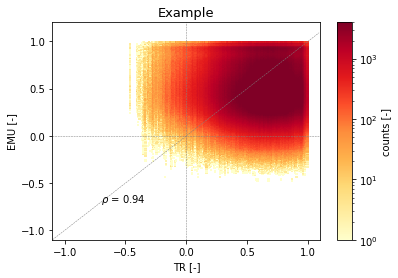

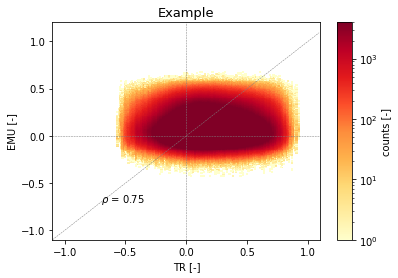

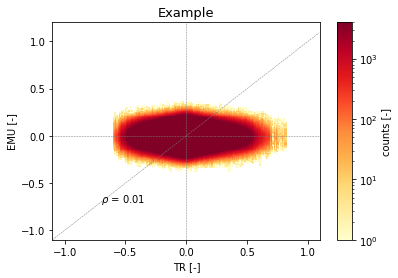

In [123]:
plt.figure()
plot_hist_spar_crosscorr('CESM2', lower=1500)
plt.figure()
plot_hist_spar_crosscorr('CESM2', lower=1500,upper=3000,which='between')
plt.figure()
plot_hist_spar_crosscorr('CESM2', lower=1500,upper=3000,which='above')

In [6]:
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'

model_names=joblib.load(dir_in_data_mod+'labels.pkl')

test_label=[]
label_act=[]
for i in model_names[4:]:
    try:
        test_label.append(int(i.split('(')[1].split(')')[0]))
        label_act.append(i.split('(')[0])
    except:
        label_act.append(i)
        test_label.append(0)
        
models_te=[model for i_mod, model in enumerate(models) if test_label[i_mod]!=0] 

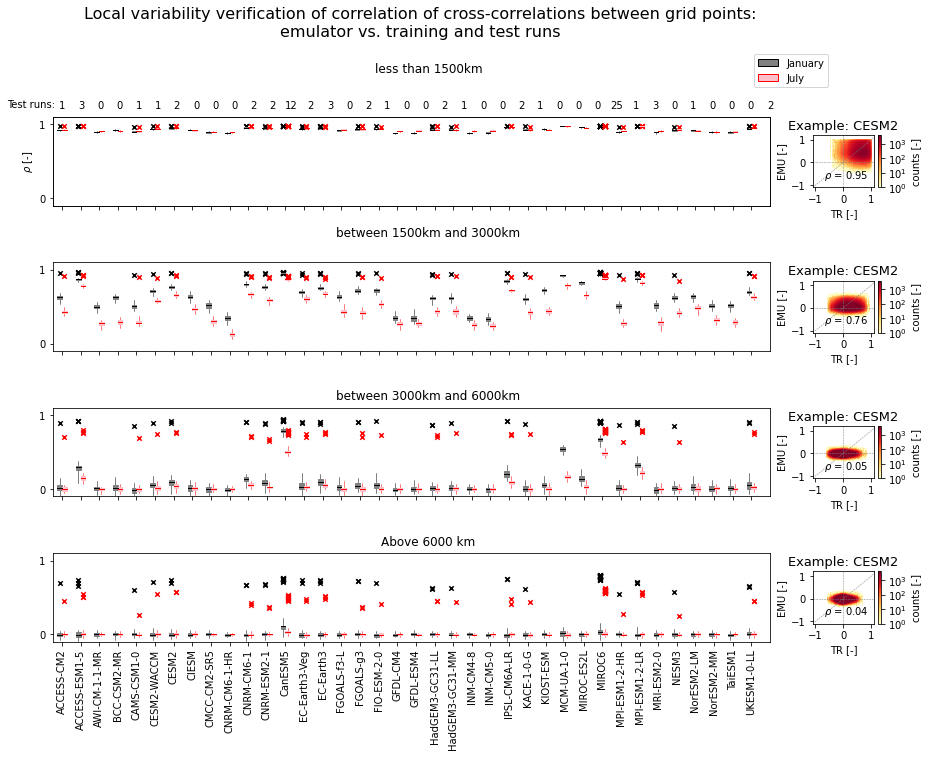

In [25]:

from matplotlib.patches import Patch


fs_title=16
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
n_row = 11*4
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'
labels=joblib.load(dir_in_data_mod+'labels.pkl')

corr_s_below_te = joblib.load(dir_in_data_mod+'tas_test_spat_cross_corr_below.pkl')
corr_s_between_te_r = joblib.load(dir_in_data_mod+'tas_test_spat_cross_corr_between_r.pkl')
corr_s_between_te_l = joblib.load(dir_in_data_mod+'tas_test_spat_cross_corr_between_l.pkl')
corr_s_above_te = joblib.load(dir_in_data_mod+'tas_test_spat_cross_corr_above.pkl')
corr_s_below =  joblib.load(dir_in_data_mod+'tas_emu_spat_cross_corr_below.pkl')
corr_s_between_r =  joblib.load(dir_in_data_mod+'tas_emu_spat_cross_corr_between_r.pkl')
corr_s_between_l =  joblib.load(dir_in_data_mod+'tas_emu_spat_cross_corr_between_l.pkl')
corr_s_above = joblib.load(dir_in_data_mod+'tas_emu_spat_cross_corr_above.pkl')

#plt.figure(figsize=(12, n_row * 1.2))
plt.figure(figsize=(15, 14))

plt.rcParams.update({'font.size': 10})
#plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

#grid = plt.GridSpec(n_row*7+6, 81, wspace=0, hspace=0.15) # create a grid for the subplots #0.12
grid = plt.GridSpec(42, 98, wspace=0, hspace=0.15) # create a grid for the subplots #0.12

axtitle = plt.subplot(grid[0,:-12])
plt.title('Local variability verification of correlation of cross-correlations between grid points:\n'+r'emulator vs. training and test runs',y=-0,fontsize=fs_title)
plt.axis('off')
i=4

xticks= np.arange(1,len(models)+1)
xticks[1:]=xticks[1:]*2-1

xticks_1=xticks-0.25

xticks_2=xticks+0.25

ax1=plt.subplot(grid[i+1:i+6,:-14])
    
for mod in range(len(models)):
    bp1=plt.boxplot(corr_s_below[:,0,mod][~np.isnan(corr_s_below[:,0,mod])],positions=[xticks_1[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp1[element], color='black',linewidth=0.5)
        else:
            plt.setp(bp1[element], color='grey')
    plt.setp(bp1['medians'],color='black')

    bp2=plt.boxplot(corr_s_below[:,6,mod][~np.isnan(corr_s_below[:,6,mod])],positions=[xticks_2[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp2[element], color='red',linewidth=0.5)   
        else:
            plt.setp(bp2[element], color='pink')

    plt.setp(bp2['medians'],color='red')


    if models[mod] in models_te:
        for k in np.arange(corr_s_above_te.shape[0]):
            plt.scatter(xticks_1[mod],corr_s_below_te[k,0,mod],marker='x',color='k',s=20)


        for k in np.arange(corr_s_above_te.shape[0]):
            plt.scatter(xticks_2[mod],corr_s_below_te[k,6,mod],marker='x',color='r',s=20)

plt.yticks([0,1],[0,1])

xk=plt.xticks(xticks, [])
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([0,(len(models))*2+1])

ax2 = ax1.twiny()
ax2.set_xlim(0,len(models)+1)
ax2.set_xticks(xticks)
ax2.set_xticklabels(test_label)
ax2.tick_params(axis='x', which = "both", bottom = False, top = False, labelsize=10)                    
            
axtitle = plt.subplot(grid[3,1])
plt.title('Test runs:',y=-1.08,x=-3.5,fontsize=10)
ax1.set_ylabel(r'$\rho$ [-]')
plt.axis('off')

ax3=plt.subplot(grid[i+2:i+5,-9:])
plot_hist_spar_crosscorr('CESM2')

    
i+=8

ax1=plt.subplot(grid[i+1:i+6,:-14])

xticks= np.arange(1,len(models)+1)
xticks[1:]=xticks[1:]*2-1

xticks_1=xticks-0.25

xticks_2=xticks+0.25

    
for mod in range(len(models)):
    bp1=plt.boxplot(corr_s_between_r[:,0,mod][~np.isnan(corr_s_between_r[:,0,mod])],positions=[xticks_1[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp1[element], color='black',linewidth=0.5)
        else:
            plt.setp(bp1[element], color='grey')
    plt.setp(bp1['medians'],color='black')

    bp2=plt.boxplot(corr_s_between_r[:,6,mod][~np.isnan(corr_s_between_r[:,6,mod])],positions=[xticks_2[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp2[element], color='red',linewidth=0.5)   
        else:
            plt.setp(bp2[element], color='pink')

    plt.setp(bp2['medians'],color='red')


    if models[mod] in models_te:
        for k in np.arange(corr_s_above_te.shape[0]):
            plt.scatter(xticks_1[mod],corr_s_between_te_r[k,0,mod],marker='x',color='k',s=20)


        for k in np.arange(corr_s_above_te.shape[0]):
            plt.scatter(xticks_2[mod],corr_s_between_te_r[k,6,mod],marker='x',color='r',s=20)

plt.yticks([0,1],[0,1])

xk=plt.xticks(xticks, [])
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([0,(len(models))*2+1])

ax3=plt.subplot(grid[i+2:i+5,-9:])
plot_hist_spar_crosscorr('CESM2',which='between',lower=1500,upper=3000)
 
i+=8

ax1=plt.subplot(grid[i+1:i+6,:-14])

xticks= np.arange(1,len(models)+1)
xticks[1:]=xticks[1:]*2-1

xticks_1=xticks-0.25

xticks_2=xticks+0.25

    
for mod in range(len(models)):
    bp1=plt.boxplot(corr_s_between_l[:,0,mod][~np.isnan(corr_s_between_l[:,0,mod])],positions=[xticks_1[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp1[element], color='black',linewidth=0.5)
        else:
            plt.setp(bp1[element], color='grey')
    plt.setp(bp1['medians'],color='black')

    bp2=plt.boxplot(corr_s_between_l[:,6,mod][~np.isnan(corr_s_between_l[:,6,mod])],positions=[xticks_2[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp2[element], color='red',linewidth=0.5)   
        else:
            plt.setp(bp2[element], color='pink')

    plt.setp(bp2['medians'],color='red')


    if models[mod] in models_te:
        for k in np.arange(corr_s_above_te.shape[0]):
            plt.scatter(xticks_1[mod],corr_s_between_te_l[k,0,mod],marker='x',color='k',s=20)


        for k in np.arange(corr_s_above_te.shape[0]):
            plt.scatter(xticks_2[mod],corr_s_between_te_l[k,6,mod],marker='x',color='r',s=20)

plt.yticks([0,1],[0,1])

xk=plt.xticks(xticks, [])
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([0,(len(models))*2+1])

ax3=plt.subplot(grid[i+2:i+5,-9:])
plot_hist_spar_crosscorr('CESM2',which='between',lower=3000,upper=6000)
 
i+=8

ax1=plt.subplot(grid[i+1:i+6,:-14])

xticks= np.arange(1,len(models)+1)
xticks[1:]=xticks[1:]*2-1

xticks_1=xticks-0.25

xticks_2=xticks+0.25

    
for mod in range(len(models)):
    bp1=plt.boxplot(corr_s_above[:,0,mod][~np.isnan(corr_s_above[:,0,mod])],positions=[xticks_1[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp1[element], color='black',linewidth=0.5)
        else:
            plt.setp(bp1[element], color='grey')
    plt.setp(bp1['medians'],color='black')

    bp2=plt.boxplot(corr_s_above[:,6,mod][~np.isnan(corr_s_above[:,6,mod])],positions=[xticks_2[mod]],whis=[0,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.5)
    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp2[element], color='red',linewidth=0.5)   
        else:
            plt.setp(bp2[element], color='pink')

    plt.setp(bp2['medians'],color='red')


    if models[mod] in models_te:
        for k in np.arange(corr_s_above_te.shape[0]):
            plt.scatter(xticks_1[mod],corr_s_above_te[k,0,mod],marker='x',color='k',s=20)


        for k in np.arange(corr_s_above_te.shape[0]):
            plt.scatter(xticks_2[mod],corr_s_above_te[k,6,mod],marker='x',color='r',s=20)

plt.yticks([0,1],[0,1])

xk=plt.xticks(xticks, label_act,rotation=90)
ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([0,(len(models))*2+1])

ax3=plt.subplot(grid[i+2:i+5,-9:])
plot_hist_spar_crosscorr('CESM2',which='above')

#axtitle=plt.subplot(grid[2,:7])
#plt.title('CMIP5',y=0.2)
#plt.axis('off')

axtitle=plt.subplot(grid[2,5:-15])
plt.title('less than 1500km',y=-0.02)
plt.axis('off')

axtitle=plt.subplot(grid[11,5:-15])
plt.title('between 1500km and 3000km',y=-0.02)
plt.axis('off')

axtitle=plt.subplot(grid[20,5:-15])
plt.title('between 3000km and 6000km',y=-0.02)
plt.axis('off')

axtitle=plt.subplot(grid[28,5:-15])
plt.title('Above 6000 km',y=-0.02)
plt.axis('off')


legend_elements = [Patch(facecolor='grey', edgecolor='k',
                         label='January'),
                  Patch(facecolor='pink', edgecolor='r',
                         label='July')]

axlegend=plt.subplot(grid[1:4,-15:-8])
plt.legend(handles=legend_elements, loc='center')
plt.axis('off')

plt.savefig('/net/so4/landclim/snath/loc_var_spat_veri.pdf', dpi=300)

In [13]:
from scipy.signal import periodogram, welch, csd
from scipy.stats import pearsonr
import datetime as dt

frequencies_emu_pc={}
frequencies_te_pc={}
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'

#frequencies_emu_pc=joblib.load(dir_in_data_mod+'emu_PSD_PC_loc_var_tas.pkl')
#frequencies_te_pc=joblib.load(dir_in_data_mod+'test_PSD_PC_loc_var_tas.pkl')

for model in models[19:]:
    
    print('Calculating PSD-PC score for: ', model)
    nr_emus=emu_res_fmin[model].shape[0]
    
    frequencies_emu_pc[model]=np.zeros([nr_emus])
    frequencies_te_pc[model]=np.zeros([len(test_run_nrs[model])])
    
    all_psd_esm_tr=np.zeros([50,idx_l.sum()])
    all_freq_esm_tr=np.zeros([50,idx_l.sum()])
    all_psd_emu_tr=np.zeros([nr_emus,50,idx_l.sum()])
    all_psd_esm_te=np.zeros([len(test_run_nrs[model]),50,idx_l.sum()])
    
    start = dt.datetime.now()
    for i_grid in np.arange(idx_l.sum()):
        
        freq_temp_esm_tr={}
        psd_temp_esm_tr={}
        for i_run in range(len(run_nrs[model])):
            freq_temp_esm_tr[i_run],psd_temp_esm_tr[i_run]=welch(train_residue_all[model].reshape(len(run_nrs[model]),-1,idx_l.sum())[i_run,:,i_grid].flatten())
        
        all_psd_esm_temp_tr=np.stack(([psd_temp_esm_tr[i_run] for i_run in range(len(run_nrs[model]))]))
        all_freq_esm_temp_tr=np.stack(([freq_temp_esm_tr[i_run] for i_run in range(len(run_nrs[model]))]))
        
        all_psd_esm_temp_tr=np.mean(all_psd_esm_temp_tr,axis=0)
        all_freq_esm_temp_tr=np.mean(all_freq_esm_temp_tr,axis=0)

        all_psd_esm_tr[:,i_grid]=all_psd_esm_temp_tr[np.argsort(all_freq_esm_temp_tr)[::-1]][:50]
        all_freq_esm_tr[:,i_grid]=all_freq_esm_temp_tr[np.argsort(all_freq_esm_temp_tr)[::-1]][:50]
        
        
        for i_emu in range(nr_emus):
            freq_temp_emu_tr,psd_temp_emu_tr=welch(emu_res_fmin[model][i_emu,:,:,i_grid].flatten())
            all_psd_emu_tr[i_emu,:,i_grid]=np.interp(all_freq_esm_tr[:,i_grid],freq_temp_emu_tr,psd_temp_emu_tr)
                               
        for i_run in range(len(test_run_nrs[model])):
            freq_temp_esm_te,psd_temp_esm_te=welch(test_residue_all[model].reshape(len(test_run_nrs[model]),-1,idx_l.sum())[i_run,:,i_grid].flatten())
            all_psd_esm_te[i_run,:,i_grid]=np.interp(all_freq_esm_tr[:,i_grid],freq_temp_esm_te,psd_temp_esm_te)
        
    for i_emu in range(nr_emus):          
        frequencies_emu_pc[model][i_emu]=pearsonr(all_psd_emu_tr[i_emu,:,:].flatten(),all_psd_esm_tr.flatten())[0]
    for i_run in range(len(test_run_nrs[model])):    
        frequencies_te_pc[model][i_run]=pearsonr(all_psd_esm_te[i_run,:,:].flatten(),all_psd_esm_tr.flatten())[0]

    time_taken = dt.datetime.now() - start
    print('time taken: ',time_taken)
        

Calculating PSD-PC score for:  GFDL-ESM4
time taken:  0:00:45.452452
Calculating PSD-PC score for:  HadGEM3-GC31-LL
time taken:  0:01:43.291821
Calculating PSD-PC score for:  HadGEM3-GC31-MM
time taken:  0:01:44.571459
Calculating PSD-PC score for:  INM-CM4-8
time taken:  0:00:51.886309
Calculating PSD-PC score for:  INM-CM5-0
time taken:  0:00:48.679505
Calculating PSD-PC score for:  IPSL-CM6A-LR
time taken:  0:03:05.746199
Calculating PSD-PC score for:  KACE-1-0-G
time taken:  0:01:43.704220
Calculating PSD-PC score for:  KIOST-ESM
time taken:  0:00:53.252215
Calculating PSD-PC score for:  MCM-UA-1-0
time taken:  0:00:49.385491
Calculating PSD-PC score for:  MIROC-ES2L
time taken:  0:00:51.616696
Calculating PSD-PC score for:  MIROC6
time taken:  0:23:51.644497
Calculating PSD-PC score for:  MPI-ESM1-2-HR
time taken:  0:00:52.157549
Calculating PSD-PC score for:  MPI-ESM1-2-LR
time taken:  0:06:14.678542
Calculating PSD-PC score for:  MRI-ESM2-0
time taken:  0:00:51.489289
Calculatin

In [14]:
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'

joblib.dump(frequencies_emu_pc,dir_in_data_mod+'emu_PSD_PC_loc_var_tas.pkl')
joblib.dump(frequencies_te_pc,dir_in_data_mod+'test_PSD_PC_loc_var_tas.pkl')

['/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/test_PSD_PC_loc_var_tas.pkl']

In [16]:
from matplotlib.colors import LogNorm
from scipy.signal import periodogram, welch, csd

def plot_hist_psd(model):
    ax_min = 0
    ax_max = 90
    spacing = 0.5
    extent=np.arange(ax_min,ax_max+spacing,spacing)
    
    nr_emus=emu_res_fmin[model].shape[0]
    
    all_psd_esm_tr=np.zeros([50,idx_l.sum()])
    all_freq_esm_tr=np.zeros([50,idx_l.sum()])
    all_psd_emu_tr=np.zeros([nr_emus,50,idx_l.sum()])


    
    for i_grid in np.arange(idx_l.sum()):
        freq_temp_esm_tr={}
        psd_temp_esm_tr={}
        for i_run in range(len(run_nrs[model])):
            freq_temp_esm_tr[i_run],psd_temp_esm_tr[i_run]=welch(train_residue_all[model].reshape(len(run_nrs[model]),-1,idx_l.sum())[i_run,:,i_grid].flatten())
            
        all_psd_esm_temp_tr=np.stack(([psd_temp_esm_tr[i_run] for i_run in range(len(run_nrs[model]))]))
        all_freq_esm_temp_tr=np.stack(([freq_temp_esm_tr[i_run] for i_run in range(len(run_nrs[model]))]))

        all_psd_esm_temp_tr=np.mean(all_psd_esm_temp_tr,axis=0)
        all_freq_esm_temp_tr=np.mean(all_freq_esm_temp_tr,axis=0)

        all_psd_esm_tr[:,i_grid]=all_psd_esm_temp_tr[np.argsort(all_freq_esm_temp_tr)[::-1]][:50]
        all_freq_esm_tr[:,i_grid]=all_freq_esm_temp_tr[np.argsort(all_freq_esm_temp_tr)[::-1]][:50]


    for i_emu in range(nr_emus):
        for i_grid in np.arange(idx_l.sum()):
            freq_temp_emu_tr,psd_temp_emu_tr=welch(emu_res_fmin[model][i_emu,:,:,i_grid].flatten())
            all_psd_emu_tr[i_emu,:,i_grid]=np.interp(all_freq_esm_tr[:,i_grid],freq_temp_emu_tr,psd_temp_emu_tr)


    _,_,_,im=plt.hist2d(np.repeat(all_psd_esm_tr,nr_emus,axis=0).flatten()/np.repeat(all_freq_esm_tr,nr_emus,axis=0).flatten()
                        ,all_psd_emu_tr.flatten()/np.repeat(all_freq_esm_tr,nr_emus,axis=0).flatten(),bins=1000,norm=LogNorm(),vmin=1,vmax=4000,cmap='YlOrRd',rasterized=True) #used to be Reds_r
    plt.text(x=1.5,y=73,s=r'$\rho$ = %.2f' %pearsonr(all_psd_esm_tr.flatten(),all_psd_emu_tr.reshape(nr_emus,-1)[50,:])[0])

    
    plt.plot(np.arange(-25,95,0.05),np.arange(-25,95,0.05),color='grey',ls='--',lw=0.5)
    plt.xlim([-20,90])
    plt.ylim([-20,90])
    plt.axhline(0,color='grey',ls='--',lw=0.5)
    plt.axvline(0,color='grey',ls='--',lw=0.5)
    plt.xlabel(r'TR [$V^2/Hz$]')
 
    
    plt.ylabel(r'EMU [$V^2/Hz$]')

    
    cbar=plt.colorbar()
    cbar.set_ticks([1,10,100,1000])
    cbar.set_label('counts [-]')

    #plt.title('CESM1(CAM5)')
    plt.title('Example: CESM2',fontsize=13)
    return im

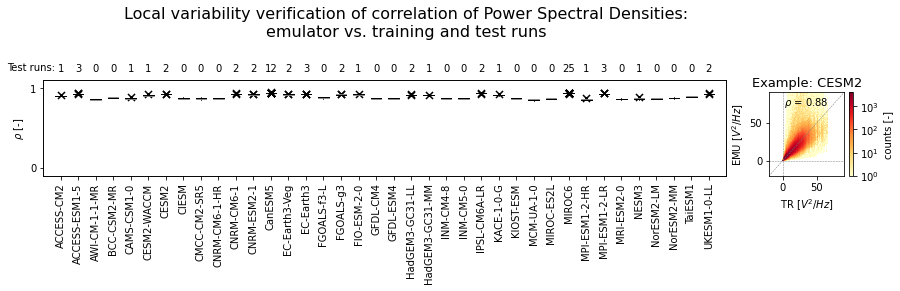

In [24]:
fs_title=16

dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'
labels=joblib.load(dir_in_data_mod+'labels.pkl')

frequencies_emu_pc=joblib.load(dir_in_data_mod+'emu_PSD_PC_loc_var_tas.pkl')
frequencies_te_pc=joblib.load(dir_in_data_mod+'test_PSD_PC_loc_var_tas.pkl')


#plt.figure(figsize=(12, n_row * 1.2))
plt.figure(figsize=(15,4))

plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'it'}) 

grid = plt.GridSpec(18, 98, wspace=0, hspace=0.15) # create a grid for the subplots #0.12

axtitle = plt.subplot(grid[0,:-9])
plt.title('Local variability verification of correlation of Power Spectral Densities:\n'+r'emulator vs. training and test runs',y=-0,fontsize=fs_title)
plt.axis('off')
i=3

xticks= np.arange(1,len(models)+1)


ax1=plt.subplot(grid[i+1:-6,2:-16])
    
    
for mod in range(len(models)):
    
    if models[mod]=='IPSL-CM6A-LR':
        bp1=plt.boxplot(frequencies_emu_pc[models[mod]][np.argsort(frequencies_emu_pc[models[mod]])[::-1]][:3],positions=[xticks[mod]],whis=[0.,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.6)
    else:
        bp1=plt.boxplot(frequencies_emu_pc[models[mod]],positions=[xticks[mod]],whis=[0.,100],showfliers=False,showcaps=False,patch_artist=True,widths=0.6)

    for element in ['boxes', 'whiskers']:
        if element=='whiskers':
            plt.setp(bp1[element], color='black',linewidth=0.8)
        else:
            plt.setp(bp1[element], color='grey',linewidth=0.8)
    plt.setp(bp1['medians'],color='black')
        
        

    if models[mod] in models_te:
        plt.scatter(np.repeat(xticks[mod],frequencies_te_pc[models[mod]].shape[0]),
                              frequencies_te_pc[models[mod]],marker='x',color='k',s=50)

plt.ylim(-0.1,1.1)
plt.yticks([0,1])


xk=plt.xticks(xticks, label_act, rotation='vertical')  

ax1.set_ylim([-0.1,1.1])
ax1.set_xlim([0,(len(models))+1])
                    
ax2 = ax1.twiny()
ax2.set_xlim(0,len(models)+1)
ax2.set_xticks(xticks)
ax2.set_xticklabels(test_label)
ax2.tick_params(axis='x', which = "both", bottom = False, top = False, labelsize=10)                    
            
axtitle = plt.subplot(grid[3,1])
plt.title('Test runs:',y=0.18,x=-0.4,fontsize=10)
ax1.set_ylabel(r'$\rho$ [-]')
plt.axis('off')

ax3=plt.subplot(grid[i+2:-6,-11:])
plot_hist_psd('CESM2')
plt.savefig('/net/so4/landclim/snath/loc_var_time_veri.pdf',dpi=300)